In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from math import pi, log, e
from sys import float_info as fi

In [ ]:
class PAk():
  def __init__(self, data, threshold = 23.928):
    self.data = data
    self.threshold = threshold # = D_thr
    self.d = data.shape[1]
    self.__hypersphereVolume = self.__computeUnitaryHypersphereVolume(self.d)
    # ^ This is used to compute the hypervolume in "computeDensities"
    self.nPoints = self.data.shape[0]
    self.densities = np.zeros(self.nPoints)
    self.distances = self.__computeDistanceMatrix()
    self.clusterArr = np.zeros(self.nPoints)
    self.arrCounter = np.zeros(self.nPoints)

  def __computeDistanceMatrix(self):
    # Computes the distance matrix. May throw warnings due to values < 0 in the sqrt.
    # This is due to machine precision errors.
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      x2 = np.sum(self.data**2, axis=1)
      xx = np.matmul(self.data, self.data.T)
      result = np.nan_to_num(np.sqrt(x2 + x2.reshape(-1, 1) - 2*xx))
    return result

  def __computeUnitaryHypersphereVolume(self,dims):
    """
    From https://www.wikiwand.com/en/Volume_of_an_n-ball#Two-dimension_recurrence_relation.
    Computes the volume of an Hypersphere of dimension 'dims' and radius 1.
    """
    if dims == 0:
      return 1
    elif dims == 1:
      return 2 #*r
    else:
      volMinus2 = self.__computeUnitaryHypersphereVolume(dims-2)
      return (2*pi)/dims * volMinus2 # * r^2


  def computeDensities(self):
    """
    Computes the Densities with the Point Adaptive KNN.
    """
    dists = self.distances                                                      # Initializes the distance matrix
    order = dists.argsort(axis = 1)                                             # We get the sorted indices by row...
    sortedDists = np.take_along_axis(dists, order, axis = 1)                    # And sort the distances.

    #Auxiliary Variables
    oldVik = 0
    oldK = 1

    #This arrays will be used to contain the densities.
    kArray = np.zeros(self.nPoints)
    vkArray = np.zeros(self.nPoints)

    for rowIndex, _ in enumerate(self.data):                                    # For each point i in the dataset,
      for k in range(2, self.nPoints-1):                                             # Check the kNN:
        radius = sortedDists[rowIndex, k]                                       # The radius of the hypersphere is equal to the already computed distance.
        vik = self.__hypersphereVolume * pow(radius, self.d)                    # and compute the volume.
                                                                                # If j is k+1 NN,
        jIndex = order[rowIndex,k+1]                                            # We then compute the hypervolume between j and j's kNN.
        radiusJ = sortedDists[jIndex, k]
        vjk = self.__hypersphereVolume * pow(radiusJ, self.d)

        # What if vik = 0? Due to machine error or overlapping points:
        vik = fi.min if vik == 0 else vik
        vjk = fi.min if vjk == 0 else vjk


        dki = -2 * k * (log(vik) + log(vjk) - 2 * log(vik+vjk) + log(4))        # The D value is computed following Eq. (3)

        if dki >= self.threshold:                                               # If it goes over the threshold, we break.
          break

        oldK = k
        oldVik = vik

      kArray[rowIndex] = oldK                                                   # We store the k and the volumes...
      vkArray[rowIndex] = oldVik

    # And compute densities,
    densities = kArray/vkArray
    # And errors (Eq. (5))
    errors = np.sqrt(
        ((4 * kArray) + 2) / ((kArray-1) * kArray)
    ).reshape(-1,1)
    self.densities = densities
    return densities, errors, kArray

  def computeDistsDensity(self):
    sortedIndices = np.argsort(self.densities)
    sortedDensities = self.densities[sortedIndices]
    minDists = np.zeros(self.nPoints)
    for densIndex, ptIndex in enumerate(sortedIndices):
      if densIndex == self.nPoints-1:
        minDists[ptIndex] = minDists[ptIndex] * 1.05
      else:
        greaterDens = sortedIndices[densIndex+1: self.nPoints]
        minDists[ptIndex] = np.min(self.distances[ptIndex, greaterDens])
    return minDists

  def computeDensityPeaks(self, minDists, clusterIndices, tries = 10):

    order = self.distances.argsort(axis = 1)[:,1:]
    #nearestPtsDists = np.take_along_axis(self.distances, order, axis = 0)
    #sortedIndices = np.argsort(self.densities)
    self.arrCounter = np.zeros(self.nPoints)

    for clInd, ptInd in enumerate(clusterIndices):
      self.clusterArr[ptInd] = clInd + 1

    for t in range(tries):
      for i in range(self.nPoints):
        if self.clusterArr[i] == 0:
          self.__clusterAssignment(i, order)

  def __clusterAssignment(self, ptIndex, order):
    for i in order[ptIndex, :]:
      #print(order[ptIndex, :])
      nn = self.densities[i]
      if nn > self.densities[ptIndex]:
        #Set cluster:
        if self.clusterArr[i] == 0:
          if self.arrCounter[i] <= 2:
            self.__clusterAssignment(i, order)
          self.arrCounter[i] += 1
        self.clusterArr[ptIndex] = self.clusterArr[i]


In [ ]:
#Generating a test dataset:
nPtsUniform = 1500
nPtsGaussian = 1500
dims = 2
rng = np.random.default_rng(seed=1)
data = np.concatenate((rng.normal((0,0), 1,(nPtsGaussian, dims)),
                       rng.uniform(-5, 5,(nPtsUniform, dims))
                      ), axis = 0)

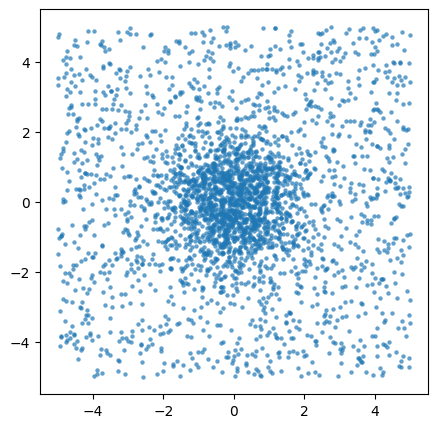

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(data[:,0], data[:,1], alpha = 0.7, linewidth = 0, s = 10)
#ax.scatter(data[674,0], data[674,1], alpha = 0.7, linewidth = 0, s = 100, c = 'r')

In [ ]:
pak = PAk(data)
densities, err, k = pak.computeDensities()
freeEnergy = -1 * np.log(densities)

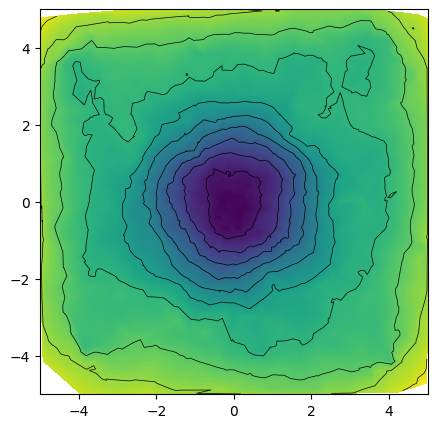

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.tricontour(data[:,0], data[:,1], freeEnergy, levels=10, linewidths=0.5, colors="k", linestyles = "solid")
ax.tricontourf(data[:,0], data[:,1], freeEnergy, levels=250)

In [ ]:
dists = pak.computeDistsDensity()
indices = dists.argsort()[::-1][0:10]

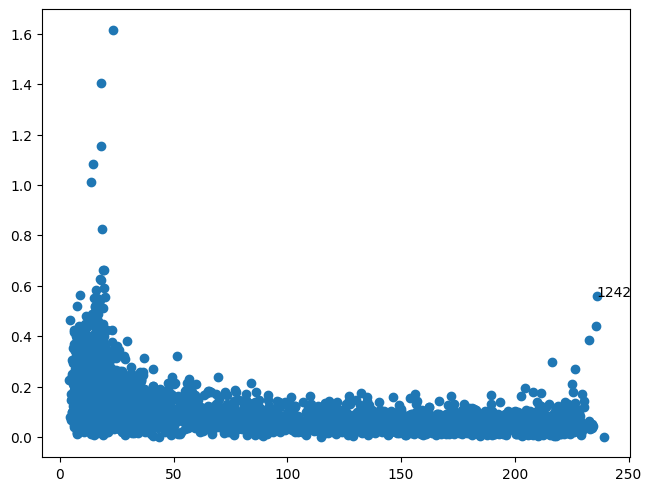

In [ ]:
fig, ax = plt.subplots(layout='constrained')
ax.scatter(densities, dists)

densCutoff = 150 #x
distCutoff = .5 #y

for n in range(pak.nPoints):
  if densities[n] > densCutoff and dists[n] > distCutoff:
    ax.annotate(f"{n}", (densities[n], dists[n]))

In [ ]:
densities.argsort()[::-1]

array([1337, 1242, 1010, ..., 2614, 1683, 2877])

##Let's test PAk:



In [ ]:
# We generate data from 9 normal distributions:
nGauss = [300, 1000, 3000]
nSigma = [0.1, 1, 3]
rng = np.random.default_rng(seed=0)
testData = np.array([], dtype=np.int64).reshape(0,2)

for ptsIndex, pts in enumerate(nGauss):
  for sigmaIndex, sigma in enumerate(nSigma):
    mu = (ptsIndex * 25, sigmaIndex * 25)
    testData = np.concatenate((testData, rng.normal(mu, sigma,(pts, 2))), axis = 0)

In [ ]:
#And apply PAk:
pak2 = PAk(testData)
densities2, err2, k2 = pak2.computeDensities()
freeEnergy2 = -1 * np.log(densities2)

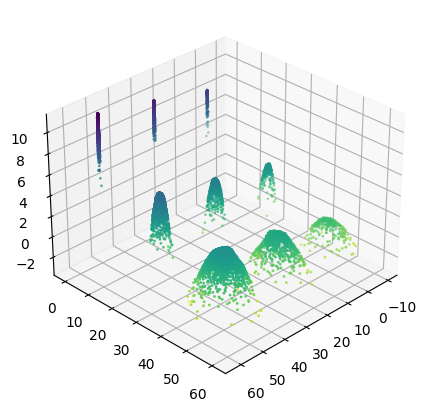

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection = "3d")
ax.view_init(30,45,0)
ax.scatter(testData[:,0], testData[:,1], np.log(densities2), s = 1, c = - 1 * np.log(densities2))

#Proteins


In [ ]:
import pandas as pd
from sklearn.manifold import MDS

In [ ]:
#trp["temperature [k]"].unique()
#Output:
# array([300.  , 304.  , 308.15, 312.46, 316.92, 321.54, 326.31, 331.23,
#        336.31, 341.54, 346.92, 352.46, 358.15, 364.  , 370.  , 376.15,
#        382.46, 388.92, 395.54, 402.31, 409.23, 416.31, 423.54, 430.92,
#        438.46, 446.15, 454.  , 462.  , 470.15, 478.46, 486.92, 495.54,
#        504.31, 513.23, 522.31, 531.54, 540.92, 550.46, 560.15, 570.  ])
# We only use one temperature.

In [ ]:
# From https://www.kaggle.com/datasets/tobiasle/trp-cage-dihedrals
# PDB: IL2Y
trp = pd.read_csv("/content/drive/MyDrive/trp_cage.csv")
trp = (trp
.drop(trp.columns[41:44], axis = 1)
.query("`temperature [k]` == 300") # ~ 100°C
.drop(["temperature [k]", "time [ps]", "replica id"], axis = 1)
.sample(frac = .5, random_state = 1)) # We only use a subset, colab has only so much ram.

In [ ]:
trp

,phi0,phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,...,psi9,psi10,psi11,psi12,psi13,psi14,psi15,psi16,psi17,psi18
30140,-1.036,-1.378,-0.744,-1.286,-1.324,-1.165,-1.333,-1.430,1.917,0.998,...,0.140,-2.290,-0.292,-0.129,2.887,0.092,2.629,2.890,2.623,2.506
20207,-1.668,-1.071,-1.213,-1.270,-1.305,-0.874,-1.101,-1.312,2.753,0.952,...,-0.105,-2.540,0.123,-0.320,-0.224,0.294,2.361,2.889,2.679,2.635
8190,-1.360,-0.888,-1.175,-1.309,-1.635,-0.910,-1.386,-2.218,1.858,-1.169,...,0.554,-0.822,-0.674,-0.862,-0.534,0.647,2.700,2.449,2.313,3.036
57,-1.085,-1.332,-1.414,-1.104,-1.299,-1.158,-1.258,-1.201,3.054,1.162,...,0.005,-2.592,-0.269,-0.242,-0.496,0.432,2.620,2.923,2.625,2.152
12573,-1.365,-0.997,-1.040,-1.145,-1.120,-1.025,-1.050,-1.555,1.764,0.937,...,0.260,-2.125,-0.029,-0.090,-0.360,0.319,2.660,2.996,2.488,2.880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20292,-1.435,-1.399,-1.339,-1.155,-1.369,-1.203,-1.108,-1.320,1.683,1.113,...,0.089,-2.154,-0.442,-0.104,-0.251,0.420,2.799,2.727,2.202,2.704
16135,-0.607,-1.058,-1.383,-1.246,-1.268,-1.171,-1.130,-1.086,2.447,1.007,...,0.237,-2.297,-0.218,-0.006,-0.464,-0.009,2.490,2.661,2.098,-2.923
14037,-1.007,-1.153,-1.166,-1.264,-1.201,-1.224,-1.115,-1.354,1.385,1.400,...,0.309,-2.070,-0.334,-0.348,-0.529,-0.132,2.663,2.538,2.342,2.345
13512,-1.360,-1.278,-0.895,-1.131,-1.633,-1.060,-0.939,-1.473,1.425,1.279,...,0.228,-2.298,-0.619,-0.462,-0.409,-0.193,2.729,2.886,2.264,2.405


In [ ]:
#Plotting the Ramachandran Plots.
fig, ax = plt.subplots(6,3, figsize = (10, 20))
ax = ax.reshape(1,-1)[0]
for i, a in enumerate(ax):
  a.set_title(f"{i}")
  a.set_xlim(left=-1 * pi, right=pi)
  a.set_ylim(bottom=-1 * pi, top=pi)
  a.scatter(trp[f"psi{i}"], trp[f"phi{i}"], alpha = 0.1, linewidth = 0)

In [ ]:
trpArr = np.array(trp)
pakTrp = PAk(trpArr)
densitiesTrp, errTrp, kTrp = pakTrp.computeDensities()
distsTrp = pakTrp.computeDistsDensity()

<ipython-input-94-507c101f3afd>:4: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(densitiesTrp), np.log(distsTrp))


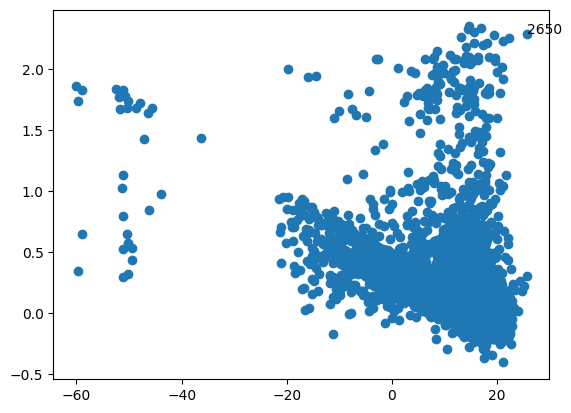

In [ ]:
dencutoff = 1e11
distcutoff = 8

plt.scatter(np.log(densitiesTrp), np.log(distsTrp))

bottom, up = plt.ylim()
left, right = plt.xlim()

#plt.plot([dencutoff, right], [distcutoff, distcutoff], color="k", linestyle="-", linewidth=2)
#plt.plot([dencutoff, dencutoff], [distcutoff, up], color="k", linestyle="-", linewidth=2)

goodpts = []

for i in range(pakTrp.nPoints):
  if distsTrp[i] > distcutoff and densitiesTrp[i] > dencutoff:
    goodpts = goodpts + [i]
    plt.annotate(i, (np.log(densitiesTrp[i]), np.log(distsTrp[i])))

In [ ]:
pakTrp.computeDensityPeaks(distsTrp, goodpts)
clustersTrp = pakTrp.clusterArr

In [ ]:
mds = MDS(max_iter=50)
trpMds = mds.fit_transform(trp)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


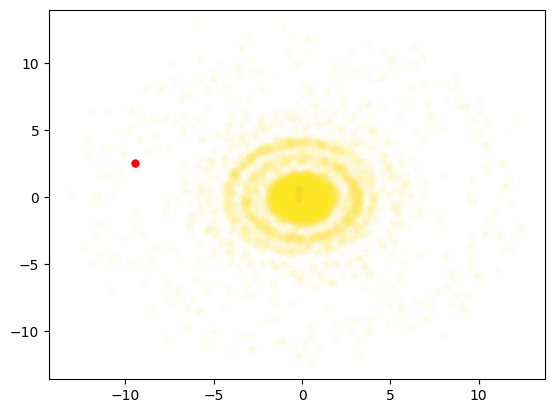

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(trpMds[:,0], trpMds[:,1], c = clustersTrp, alpha = 0.05, linewidth = 0)
ax.scatter(trpMds[goodpts,0], trpMds[goodpts,1], c = 'r', alpha = 1, linewidth = 0)

In [ ]:
np.rad2deg(trp.iloc[goodpts]).to_csv('angles.csv', index = False)

In [ ]:
np.rad2deg(trp.iloc[goodpts])